In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning

In [1]:
from IPython.display import clear_output
import numpy as np
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import AQGD
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split


In [2]:
algorithm_globals.random_seed = 2

In [3]:
n_qubits = 4

In [4]:
def layer(W):
    """Applies a layer of arbitrary rotations and circular entanglements to the variational circuit

    Args:
        W (np.ndarray): rotation parameters for the layer
    """
    qc = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        qc.u(W[i*3], W[i*3 + 1], W[i*3 + 2], i)

    for i in range(n_qubits-1):
        qc.cnot(i, i+1)

    if n_qubits > 2:
        qc.cnot(n_qubits-1, 0)

    return qc

In Qiskit, there is not basis state preparation circuit and anyway we need to work with `Parameter` objects to use the `qiskit-machine-learning` tools. So we just encode $R_Y$ rotation, pass the parameters and multiply by $\pi$.

In [5]:
def statepreparation(x):
    """Prepares the binary state fed to the vqc

    Args:
        x (List): list of 0s and 1s corresponding to the basis state
    """
    qc = QuantumCircuit(n_qubits)
    
    for i, x_i in enumerate(x):
        qc.rx(x_i * np.pi, i)

    return qc

In [6]:
n_layers = 2

weight_params = ParameterVector(name='W', length=3 * n_qubits * n_layers)
input_params = ParameterVector(name='x', length=n_qubits)

In [7]:
# prepare the quantum circuit
qc = QuantumCircuit(n_qubits)
qc = qc.compose(statepreparation(input_params))
for l in range(n_layers):
    qc = qc.compose(layer(weight_params[3 * n_qubits * l: 3 * n_qubits * (l+1)]))


In [8]:
qc.draw()

┌────────────┐ ┌───────────────────┐                                   »
q_0: ┤ Rx(π*x[0]) ├─┤ U(W[0],W[1],W[2]) ├───■───────────────────────────────»
     ├────────────┤ ├───────────────────┤ ┌─┴─┐     ┌──────────────────────┐»
q_1: ┤ Rx(π*x[1]) ├─┤ U(W[3],W[4],W[5]) ├─┤ X ├──■──┤ U(W[15],W[16],W[17]) ├»
     ├────────────┤ ├───────────────────┤ └───┘┌─┴─┐└──────────────────────┘»
q_2: ┤ Rx(π*x[2]) ├─┤ U(W[6],W[7],W[8]) ├──────┤ X ├───────────■────────────»
     ├────────────┤┌┴───────────────────┴┐     └───┘         ┌─┴─┐          »
q_3: ┤ Rx(π*x[3]) ├┤ U(W[9],W[10],W[11]) ├───────────────────┤ X ├──────────»
     └────────────┘└─────────────────────┘                   └───┘          »
«     ┌───┐┌──────────────────────┐               ┌───┐
«q_0: ┤ X ├┤ U(W[12],W[13],W[14]) ├──■────────────┤ X ├
«     └─┬─┘└──────────────────────┘┌─┴─┐          └─┬─┘
«q_1: ──┼──────────────────────────┤ X ├──■─────────┼──
«       │  ┌──────────────────────┐└───┘┌─┴─┐       │  
«q_2: ──┼──┤ U(W[18],W[19],W[20]) ├─────┤ X ├──■────┼──
«       │  ├──────────────────────┤     └───┘┌─┴─┐  │  
«q_3: ──■──┤ U(W[21],W[22],W[23]) ├──────────┤ X ├──■──
«          └──────────────────────┘          └───┘

In [9]:
# define an observable
observable = SparsePauliOp.from_list([("IIIZ", 1)])

In [10]:
# define the qnn
qnn = EstimatorQNN(circuit=qc, observables=observable, input_params=input_params, weight_params=weight_params)

In [11]:
input_trial = [0, 1, 0, 0]
weights_init = algorithm_globals.random.random((1, qnn.num_weights))
qnn.forward(input_trial, weights_init)

array([[0.0410809]])

In [12]:
import matplotlib.pyplot as plt

# callback function that draws a live plot when the .fit() method is called
loss_hist = []


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    loss_hist.append(obj_func_eval)
    plt.title("Loss per epoch")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss value")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.show()

In [13]:
classifier = NeuralNetworkClassifier(neural_network=qnn, loss="squared_error", optimizer=AQGD(maxiter=50, eta=.5, momentum=.25), initial_point=weights_init, callback=callback_graph)

In [14]:
data = np.loadtxt("data/parity.txt")

X = np.array(data[:, :-1])
y = np.array(data[:, -1])

# shift lables from [0, 1] to [-1, 1], to match the range of expectation values
y = 2 * y - np.ones(len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=algorithm_globals.random_seed, shuffle=True)

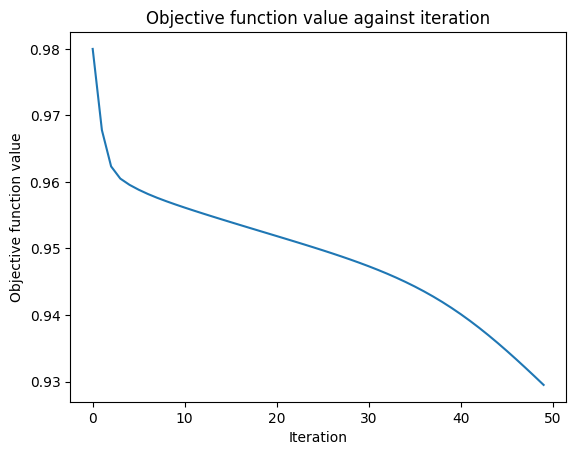

In [15]:
classifier.fit(X_train, y_train)

In [16]:
X_test

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.]])

In [17]:
classifier.score(X_test, y_test)

0.25